In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_model"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 선형 회귀

In [2]:
import numpy as np

X = 2 * np.random.rand(100 ,1) # 0 ~ 1 균일 분포 표준정규분포 난수
y = 4 + 3 * X + np.random.randn(100, 1) # 평균 0, 표준편차 1의 가우시안 표준정규분포 난수

그림 저장: generated_data_plot


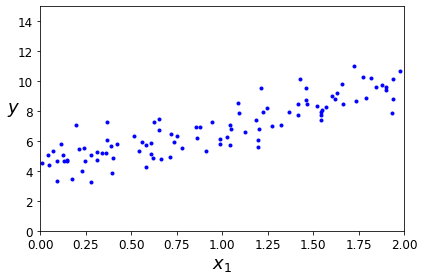

In [3]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18) # rotation : 'y' 표현
plt.axis([0, 2, 0, 15])
save_fig('generated_data_plot')
plt.show()

### 정규 방정식

$\theta^2=(X^TX)^−1X^Ty$

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

In [5]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

그림 저장: linear_model_predictions_plot


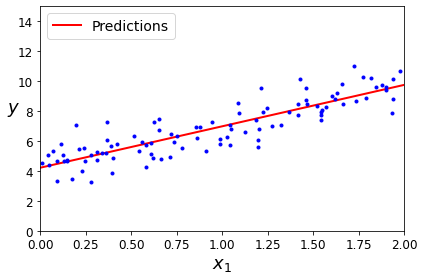

In [6]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

$\hat{y}=X\hat{\theta}$

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`Linear Regression` 클래스는 `scipy.linalg.lstsq()` 을 기반으로 함. 함수 직접 사용 가능

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\hat{\theta} = X^+y$ 계산. $X^+$는 유사역행렬

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 경사 하강법
### 배치 경사 하강법 (batch gradient descent)

**그레이디언트 벡터** <br><br>
$\nabla_\theta MSE(\theta)=\frac{2}{m}X^T(X^\theta−y)$ <br><br>
**경사 하강법 스텝** <br><br>
$\theta^{(next step)} = \theta - \nabla_\theta MSE(\theta)$

In [18]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradients
theta

array([[4.21509616],
       [2.77011339]])

In [24]:
print(X_new)
print(X_new_b)
print(X_new_b.dot(theta))

[[0]
 [2]]
[[1. 0.]
 [1. 2.]]
[[4.21509616]
 [9.75532293]]


In [149]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients # -= 로 할 경우 ??
        if theta_path is not None:
            theta_path_bgd.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title("$\eta = {}$".format(eta), fontsize=18)

그림 저장: gradient_descent_plot


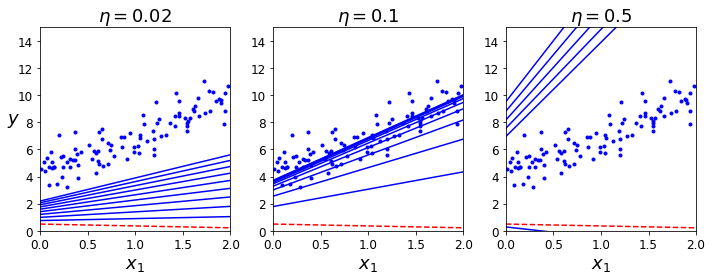

In [150]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, 0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, 0.1, theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, 0.5)

save_fig("gradient_descent_plot")
plt.show()

### 확률적 경사 하강법 (stochastic gradient descent)
- 매 스텝에서 한 개의 샘플을 무작위 선택, 그 샘플에 대한 gradient 계산
- 확룰적(무작위)이므로 불안정, 최솟값 다다를 때까지 요동치며 감소
- 불규칙 -> 지역 최솟값 건너뛰고 전역 최솟값 찾을 가능성 높음 But, 전역 최솟값에 다다르지 못하게 할 수도 있음
- 이를 해결 위해 **학습률을 점진적으로 감소**
- (금속 공학 분야의 담금질 기법 알고리즘과 유사)

In [103]:
theta_path_sgd = []
m = len(X_b)

일반적으로 한 반복에서 m번 되풀이하고, 이 때 각 반복을 **에포크(epoch)** 라고 함

그림 저장: sgd_plot


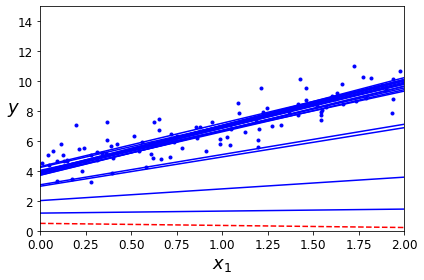

In [104]:
np.random.seed(42)
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

In [105]:
theta

array([[4.21076011],
       [2.74856079]])

In [106]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) # ravel() : 다차원 배열을 1차원 배열로 풀어줌

SGDRegressor(eta0=0.1, penalty=None)

- 최대 1000번 에포크
- 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 (tol=1e-3)
- 학습률 0.1로 기본 학습 스케줄 (eta-0.1)

In [107]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.23868557]), array([2.82181634]))

### 미니배치 경사 하강법 (mini-batch gradient descent)
- 각 스텝에서 전체 훈련 세트나 하나의 샘플이 아닌 **미니배치**라 부르는 임의의 작은 샘플에 대해 gradient 계산
- 장점 : 행렬 연산에 최적화된 하드웨어, GPU를 사용해서 얻는 성능 향상
- SGD에 비해 덜 불규칙함

In [136]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)
t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
theta

array([[4.25214635],
       [2.7896408 ]])

[- vs -= operatios with numpy](https://stackoverflow.com/questions/9047111/vs-operators-with-numpy)

In [152]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)
theta_path_bgd[:, 0][0], theta_path_bgd[:, [0]][0]

(array([1.78737583]), array([[1.78737583]]))

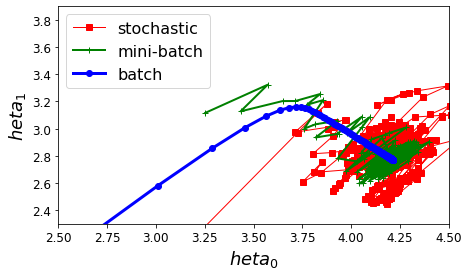

In [153]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("$\theta_0$", fontsize=18)
plt.ylabel("$\theta_1$", fontsize=18)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()